# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD, Adam
from torch.utils.data import DataLoader, Dataset
import json
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from tqdm import tqdm
import copy
import pickle
import shap

/Users/yashv/Desktop/UPenn_Courses/Labs/CSS/team-process-map/team_process_map/lib/python3.8/site-packages/shap/utils/_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
/Users/yashv/Desktop/UPenn_Courses/Labs/CSS/team-process-map/team_process_map/lib/python3.8/site-packages/shap/utils/_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecat

# Dataset

In [2]:
with open('../../model/config.json', 'rb') as file:
    config = json.load(file)
csop_cols_to_ignore = config['csop']['cols_to_ignore']
csopII_cols_to_ignore = config['csopII']['cols_to_ignore']
csop_target, csopII_target = 'zscore_efficiency', 'efficiency'

In [3]:
csop_raw = pd.read_csv('../../output/csop_output_conversation_level.csv')
csop_all_features = csop_raw.drop(csop_cols_to_ignore, axis=1)
target_scaler = StandardScaler()
csop_all_features['target'] = target_scaler.fit_transform(csop_raw[csop_target].to_numpy().reshape(-1, 1))

csopII_raw = pd.read_csv('../../output/csopII_output_conversation_level.csv')
csopII_all_features = csopII_raw.drop(csopII_cols_to_ignore, axis=1)
csopII_all_features['target'] = target_scaler.transform(csopII_raw[csopII_target].to_numpy().reshape(-1, 1))

features = list(set(csop_all_features.columns).intersection(set(csopII_all_features.columns)))
csop, csopII = csop_all_features[features].copy(), csopII_all_features[features].copy()
csop, csopII = csop.fillna(0), csopII.fillna(0)

In [4]:
X, y = csop.drop(['target'], axis=1), csop[['target']]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)
X_test, y_test = csopII.drop(['target'], axis=1), csopII[['target']]

feature_scaler = StandardScaler()
X_train = pd.DataFrame(feature_scaler.fit_transform(X_train.to_numpy()), columns=X_train.columns)
X_val = pd.DataFrame(feature_scaler.transform(X_val.to_numpy()), columns=X_val.columns)
X_test = pd.DataFrame(feature_scaler.transform(X_test.to_numpy()), columns=X_test.columns)

X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((882, 390), (98, 390), (962, 390), (882, 1), (98, 1), (962, 1))

In [5]:
feature_groupings_raw = pd.read_excel('feature_groupings_06_20_23.xlsx')
groups = feature_groupings_raw.columns[2:]
groups

Index(['Communication Frequency', 'Information / Knowledge Exchange',
       'Linguistic Features', 'Emotion', 'Cognitive Processes',
       'Perceptual Processes', 'Social Processes', 'Biological Processes',
       'Personal Concerns', 'Accommodation/\nMimicry', 'Temporal', 'Question',
       'Hedging', 'Politeness', 'Equality'],
      dtype='object')

In [6]:
rows = []
for idx, row in tqdm(feature_groupings_raw.iterrows(), total=feature_groupings_raw.shape[0]):
    if row['Level'] == 'Chat':
        for prefix in ['min_', 'max_', 'stdev_', 'average_']:
            feature_name = prefix + row['Feature Name']
            row_to_append = [feature_name] + row[groups].to_list()
            rows.append(row_to_append)
    else:
        feature_name = row['Feature Name']
        row_to_append = [feature_name] + row[groups].to_list()
        rows.append(row_to_append)
feature_groupings = pd.DataFrame(
    rows, 
    columns= [
        'Feature Name', 'Communication Frequency', 'Information / Knowledge Exchange',
        'Linguistic Features', 'Emotion', 'Cognitive Processes',
        'Perceptual Processes', 'Social Processes', 'Biological Processes',
        'Personal Concerns', 'Accommodation/\nMimicry', 'Temporal', 'Question',
        'Hedging', 'Politeness', 'Equality'
    ]
)

100%|██████████| 99/99 [00:00<00:00, 1911.57it/s]


## Creating Data Loaders

In [7]:
class CSOPDataset(Dataset):
    def __init__(self, X, y):
        self.X, self.y = X, y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return [self.X[idx], self.y[idx]]

In [8]:
train_dataset = CSOPDataset(X=X_train.to_numpy(), y=y_train.to_numpy())
val_dataset = CSOPDataset(X=X_val.to_numpy(), y=y_val.to_numpy())

In [9]:
torch.manual_seed(42)
train_dataloader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=64, shuffle=True)

# Fully Connected Neural Network Optimization

## Helper Functions

In [10]:
def calc_nn_metrics(y_true, y_pred, type='TRAIN'):
    r2 = r2_score(y_true=y_true, y_pred=y_pred).round(4)
    mse = mean_squared_error(y_true=y_true, y_pred=y_pred).round(4)
    rmse = np.sqrt(mse).round(4)
    mae = mean_absolute_error(y_true=y_true, y_pred=y_pred).round(4)

    return {'r2': r2, 'mse': mse, 'mae': mae, 'rmse': rmse}

In [11]:
class CSOPFullyConnectedNN(nn.Module):
    def __init__(self, num_input_features, num_hidden_layer_nodes=15):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_features=num_input_features, out_features=num_hidden_layer_nodes),
            nn.ReLU(),
            nn.Linear(in_features=num_hidden_layer_nodes, out_features=1)
        )

    def forward(self, X):
        return self.net(X)

In [12]:
num_hidden_layer_nodes = list(range(1, 101))
models = [CSOPFullyConnectedNN(num_input_features=X_train.shape[1], num_hidden_layer_nodes=num_hidden_layer_node) \
          for num_hidden_layer_node in num_hidden_layer_nodes]
model_names = ['num_hidden_nodes_'+str(num_nodes) for num_nodes in num_hidden_layer_nodes]
learning_rates = [0.000001, 0.000003, 0.00001, 0.00003, 0.0001, 0.0003, 0.001, 0.003]
max_epochs_list = [50, 100, 250, 500, 1000]

In [13]:
def train(model, datasets, dataloaders, num_hidden_layer_neurons=15, learning_rate=0.00003, max_epochs=200):
    X_train, X_val, y_train, y_val = datasets
    train_dataloader, val_dataloader = dataloaders
    best_mse = float('inf')
    best_weights = None
    train_losses, val_losses = [], []

    loss_fn = nn.MSELoss()
    optimizer = Adam(params=model.parameters(), lr=learning_rate)
    for epoch in range(max_epochs):
        # Training for one epoch
        model.train()
        train_loss = 0
        for (X_batch, y_batch) in train_dataloader:
            # Forward Pass
            X_batch, y_batch = X_batch.to(torch.float32), y_batch.to(torch.float32)
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # Backward Pass
            optimizer.zero_grad()
            loss.backward()
            # Weights Updates
            optimizer.step()
            train_loss += float(loss)
        # Calculating average training loss after one epoch
        avg_train_mse_loss = float(train_loss/len(train_dataloader))
        train_losses.append(avg_train_mse_loss)
        # writer.add_scalar('Training Loss', avg_train_mse_loss, epoch)
        # Validation after one epoch
        model.eval()
        val_loss = 0
        for X_batch, y_batch in val_dataloader:
            # Forward Pass
            X_batch, y_batch = X_batch.to(torch.float32), y_batch.to(torch.float32)
            y_pred = model(X_batch)
            val_mse_loss = loss_fn(y_pred, y_batch)
            val_loss += float(val_mse_loss)
        # Calculating average validation loss after one epoch
        avg_val_mse_loss = float(val_loss/len(val_dataloader))
        val_losses.append(avg_val_mse_loss)
        # writer.add_scalar('Validation Loss', avg_val_mse_loss, epoch)
        # Checking if we improved from the previous best epoch
        if avg_val_mse_loss < best_mse:
            best_mse = avg_val_mse_loss
            best_weights = copy.deepcopy(model.state_dict())
            best_epoch = epoch
    
    train_preds = model(torch.tensor(X_train.to_numpy(), dtype=torch.float32)).detach().numpy()
    val_preds = model(torch.tensor(X_val.to_numpy(), dtype=torch.float32)).detach().numpy()
    train_metrics = calc_nn_metrics(y_true=y_train, y_pred=train_preds, type='TRAIN')
    val_metrics = calc_nn_metrics(y_true=y_val, y_pred=val_preds, type='VALIDATIOn')
    

    model.load_state_dict(best_weights)
    model_cache = {
        'model': model,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'best_val_loss': min(val_losses),
        'num_hidden_layer_neurons': num_hidden_layer_neurons,
        'learning_rate': learning_rate,
        'max_epochs': max_epochs,
        'best_epoch': best_epoch,
        'train_r2': train_metrics['r2'],
        'train_mse': train_metrics['mse'],
        'train_rmse': train_metrics['rmse'],
        'train_mae': train_metrics['mae'],
        'val_r2': val_metrics['r2'],
        'val_mse': val_metrics['mse'],
        'val_rmse': val_metrics['rmse'],
        'val_mae': val_metrics['mae'],
    }
    return model_cache

## Optimization Loop (Took 2 Days)

In [14]:
# model_performances = pd.DataFrame(
#     columns=[
#         'model', 
#         'net.0.weight', 'net.0.bias',
#         'net.2.weight', 'net.2.bias',
#         'num_hidden_layer_neurons', 
#         'learning_rate', 'max_epochs', 
#         'best_epoch', 'best_val_loss',
#         'train_losses', 'val_losses',
#         'train_r2', 'train_mse', 'train_rmse', 'train_mae',
#         'val_r2', 'val_mse', 'val_rmse', 'val_mae'
#     ]
# )
# for num_hidden_layer_neurons, model in tqdm(enumerate(models), total=len(models)):
#     for learning_rate in learning_rates:
#         for max_epoch in max_epochs_list:
#             model_cache = train(
#                 model=model, 
#                 datasets=(X_train, X_val, y_train, y_val),
#                 dataloaders=(train_dataloader, val_dataloader),
#                 num_hidden_layer_neurons=num_hidden_layer_neurons+1, 
#                 learning_rate=learning_rate, 
#                 max_epochs=max_epoch
#             )
#             model_performances = pd.concat([
#                 model_performances,
#                 pd.DataFrame(
#                     index=model_performances.columns, 
#                     data=[
#                         model_cache['model'],
#                         list(model_cache['model'].state_dict()['net.0.weight'].numpy().reshape((-1,))), 
#                         list(model_cache['model'].state_dict()['net.0.bias'].numpy().reshape((-1,))),
#                         list(model_cache['model'].state_dict()['net.2.weight'].numpy().reshape((-1,))), 
#                         list(model_cache['model'].state_dict()['net.2.bias'].numpy().reshape((-1,))),
#                         model_cache['num_hidden_layer_neurons'],
#                         model_cache['learning_rate'],
#                         model_cache['max_epochs'],
#                         model_cache['best_epoch'],
#                         model_cache['best_val_loss'],
#                         model_cache['train_losses'],
#                         model_cache['val_losses'],
#                         model_cache['train_r2'],
#                         model_cache['train_mse'],
#                         model_cache['train_rmse'],
#                         model_cache['train_mae'],
#                         model_cache['val_r2'],
#                         model_cache['val_mse'],
#                         model_cache['val_rmse'],
#                         model_cache['val_mae']
#                     ]
#                 ).T
#             ], ignore_index=True)
#             with open('model_performances.pkl', 'wb') as file:
#                 pickle.dump(model_performances, file)

## Loading Model Performances and Visualization

In [15]:
with open('model_performances.pkl', 'rb') as file_handle:
    model_performances = pickle.load(file_handle)
sorted_model_performances = model_performances.sort_values(by=['best_val_loss'], ascending=[True])

In [16]:
print(sorted_model_performances.shape)
sorted_model_performances.head(50)

(4000, 8)


,model,num_hidden_layer_neurons,learning_rate,max_epochs,best_epoch,best_val_loss,train_losses,val_losses
2810,CSOPFullyConnectedNN(\n (net): Sequential(\n ...,70,0.000010,50,39,0.627438,"[0.6868786045483181, 0.6761542750256402, 0.672...","[0.7474592626094818, 0.7565968334674835, 0.736..."
3089,CSOPFullyConnectedNN(\n (net): Sequential(\n ...,77,0.000003,1000,31,0.642208,"[0.6720703669956752, 0.6707057910306113, 0.669...","[0.7261853218078613, 0.7260501980781555, 0.781..."
2729,CSOPFullyConnectedNN(\n (net): Sequential(\n ...,68,0.000003,1000,52,0.642918,"[0.674226422395025, 0.6756276445729392, 0.6798...","[0.6891339272260666, 0.8382356762886047, 0.700..."
2811,CSOPFullyConnectedNN(\n (net): Sequential(\n ...,70,0.000010,100,22,0.643305,"[0.6636330911091396, 0.6658722502844674, 0.670...","[0.761040985584259, 0.8196700811386108, 0.7155..."
969,CSOPFullyConnectedNN(\n (net): Sequential(\n ...,24,0.000003,1000,874,0.648116,"[0.7206461685044425, 0.7195225187710353, 0.716...","[0.7481343448162079, 0.7784813642501831, 0.761..."
2129,CSOPFullyConnectedNN(\n (net): Sequential(\n ...,53,0.000003,1000,424,0.648328,"[0.6829339138099125, 0.6818415735449109, 0.685...","[0.763440877199173, 0.8491076827049255, 0.7271..."
1969,CSOPFullyConnectedNN(\n (net): Sequential(\n ...,49,0.000003,1000,224,0.648717,"[0.7023829902921405, 0.6976076598678317, 0.701...","[0.7716369330883026, 0.7896795868873596, 0.729..."
2728,CSOPFullyConnectedNN(\n (net): Sequential(\n ...,68,0.000003,500,263,0.650843,"[0.6833223615373883, 0.7011609716074807, 0.688...","[0.6939012855291367, 0.7543297111988068, 0.728..."
1968,CSOPFullyConnectedNN(\n (net): Sequential(\n ...,49,0.000003,500,135,0.652236,"[0.7144106839384351, 0.7045889581952777, 0.708...","[0.8682262897491455, 0.778199702501297, 0.7806..."
3088,CSOPFullyConnectedNN(\n (net): Sequential(\n ...,77,0.000003,500,372,0.654597,"[0.6990027512822833, 0.7018172528062548, 0.694...","[0.7219156920909882, 0.7036793529987335, 0.696..."


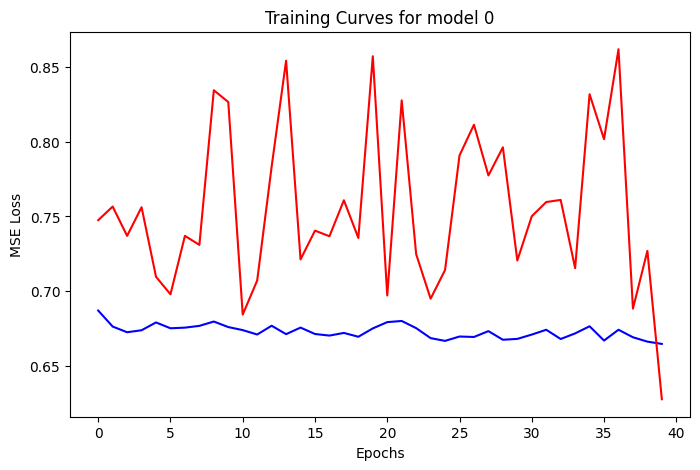

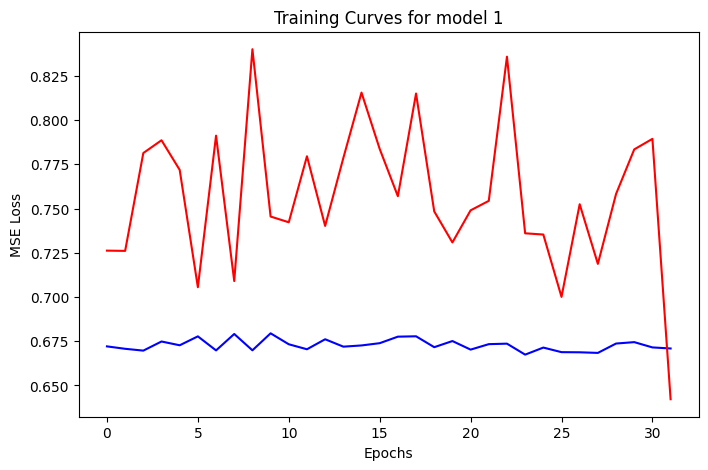

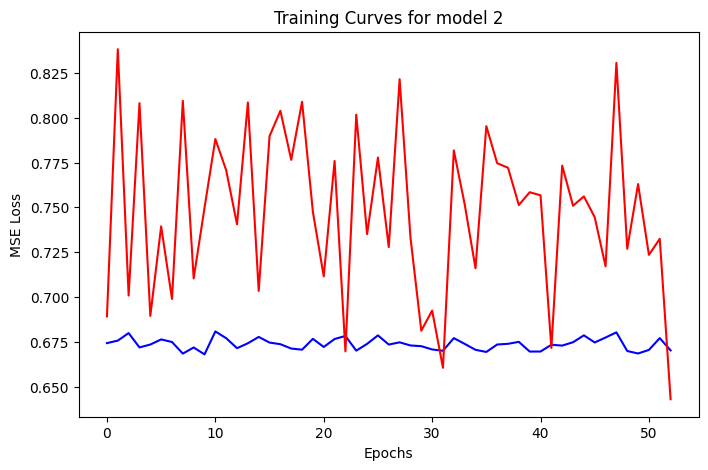

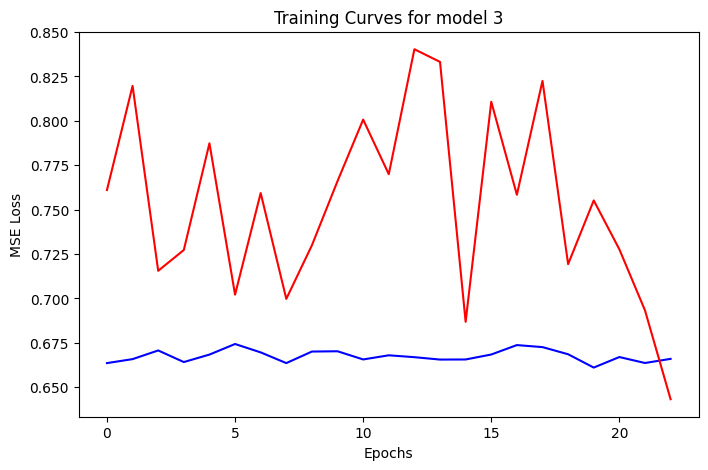

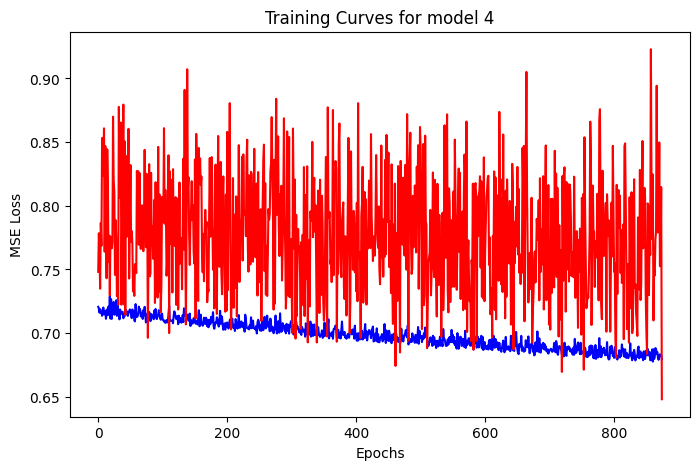

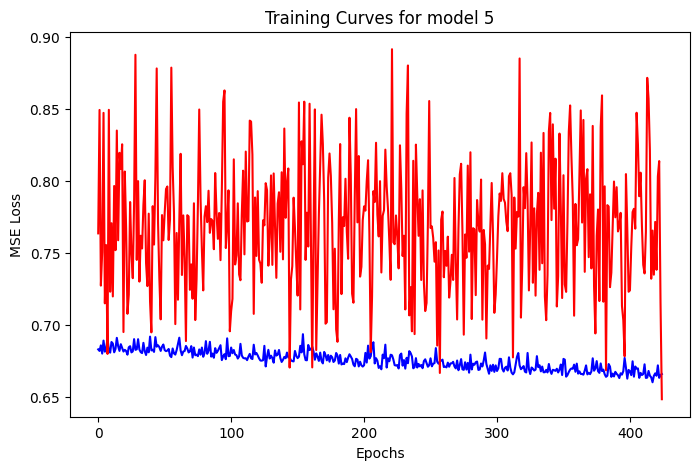

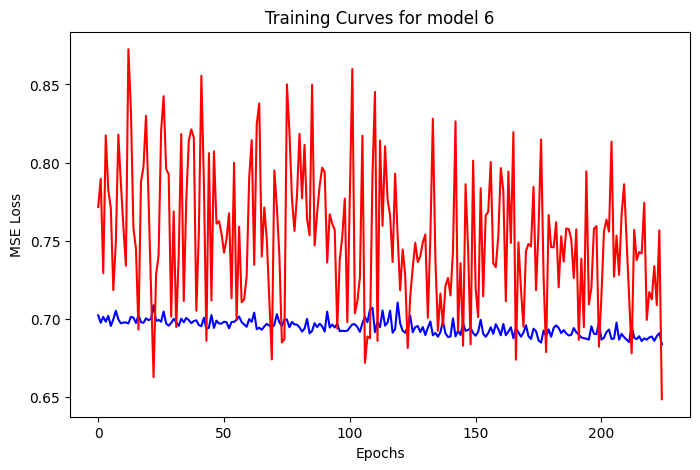

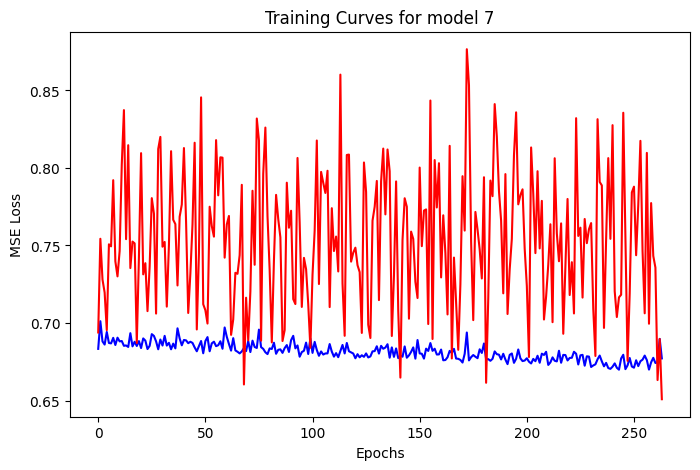

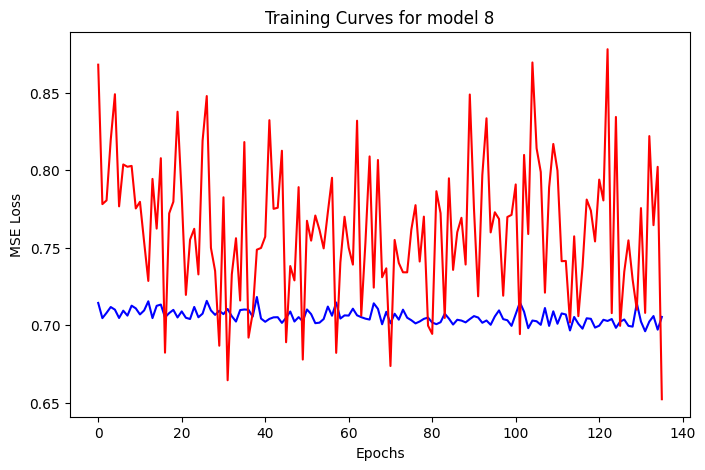

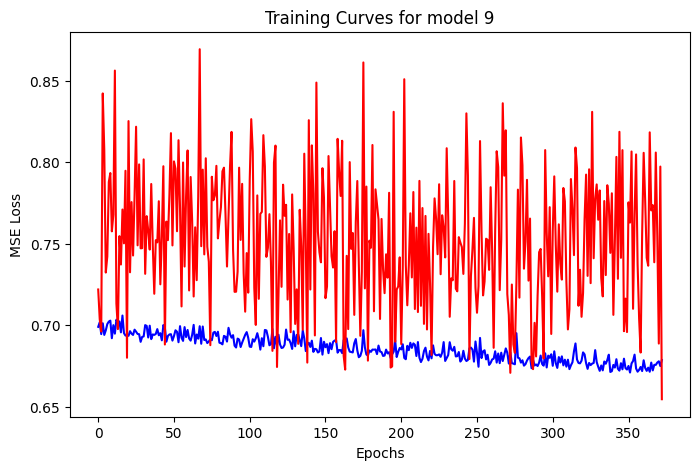

In [17]:
for idx in range(10):
    model_cache = sorted_model_performances.iloc[idx, :].to_dict()
    fig, ax = plt.subplots(figsize=(8, 5))
    ax.plot(model_cache['train_losses'][:model_cache['best_epoch']+1], label='Train Losses', color='blue')
    ax.plot(model_cache['val_losses'][:model_cache['best_epoch']+1], label='Val Losses', color='red')
    ax.set(xlabel='Epochs', ylabel='MSE Loss', title=f'Training Curves for model {idx}')
    plt.show()

# Training and Saving Optimal Model

In [ ]:
model_cache = train(
    model=CSOPFullyConnectedNN(num_input_features=X_train.shape[1], num_hidden_layer_nodes=5), 
    datasets=(X_train, X_val, y_train, y_val), 
    dataloaders=(train_dataloader, val_dataloader), 
    num_hidden_layer_neurons=5, 
    learning_rate=0.001, 
    max_epochs=100
)
torch.save(model_cache['model'].state_dict(), 'feature_bagging_nn_models/optimized_fully_connected_nn')
train_preds = model_cache['model'](torch.tensor(X_train.to_numpy(), dtype=torch.float32)).detach().numpy()
val_preds = model_cache['model'](torch.tensor(X_val.to_numpy(), dtype=torch.float32)).detach().numpy()
train_metrics = calc_nn_metrics(y_true=y_train, y_pred=train_preds, type='TRAIN')
val_metrics = calc_nn_metrics(y_true=y_val, y_pred=val_preds, type='VALIDATIOn')

In [87]:
train_metrics

{'r2': 0.3056, 'mse': 0.6858, 'mae': 0.5884, 'rmse': 0.8281}

In [88]:
val_metrics

{'r2': 0.3096, 'mse': 0.7615, 'mae': 0.6725, 'rmse': 0.8726}

# Interpreting Optimial Model Results

In [18]:
model = CSOPFullyConnectedNN(num_input_features=X_train.shape[1], num_hidden_layer_nodes=5)
model.load_state_dict(torch.load('feature_bagging_nn_models/optimized_fully_connected_nn'))

<All keys matched successfully>

In [19]:
layer_1_weights = pd.DataFrame(
    model.state_dict()['net.0.weight'].numpy().T, 
    columns=['Node1', 'Node2', 'Node3', 'Node4', 'Node5'],
    index=X_train.columns
)

In [20]:
for col in layer_1_weights.columns:
    print(f'Top Contributors for {col}')
    sorted_layer_1_weights = layer_1_weights.sort_values(by=[col], key=abs, ascending=[False])
    print(sorted_layer_1_weights[[col]].head(10))
    print('-'*50 + '\n' + '-'*50)

Top Contributors for Node1
                             Node1
max_negative_affect       0.177886
max_feel                 -0.168098
max_please_start         -0.167811
min_health               -0.164217
stdev_percept            -0.157807
stdev_body               -0.146865
max_home                 -0.139520
stdev_num_question_naive -0.127456
max_present_tense        -0.127252
max_hashedge              0.124238
--------------------------------------------------
--------------------------------------------------
Top Contributors for Node2
                             Node2
max_positive_words       -0.127797
max_please_start         -0.119186
stdev_subjunctive        -0.115504
min_third_person         -0.111827
stdev_2nd_person         -0.110987
stdev_third_person       -0.110190
max_present_tense        -0.108211
average_2nd_person_start -0.097188
average_death            -0.088269
average_quantifier        0.086834
--------------------------------------------------
-----------------------

In [21]:
layer_2_weights = pd.DataFrame(
    model.state_dict()['net.2.weight'].numpy().T, 
    index=['Node1', 'Node2', 'Node3', 'Node4', 'Node5'],
    columns=['OutputNode']
)

In [22]:
layer_2_weights

,OutputNode
Node1,-0.152145
Node2,-0.292521
Node3,0.054309
Node4,-0.431972
Node5,0.160778


# SHAP Summary Plots of Top Features

In [26]:
explainer = shap.DeepExplainer(model, torch.tensor(X_train.to_numpy(), dtype=torch.float32))

In [27]:
shap_values = explainer.shap_values(torch.tensor(X_val.to_numpy(), dtype=torch.float32))

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


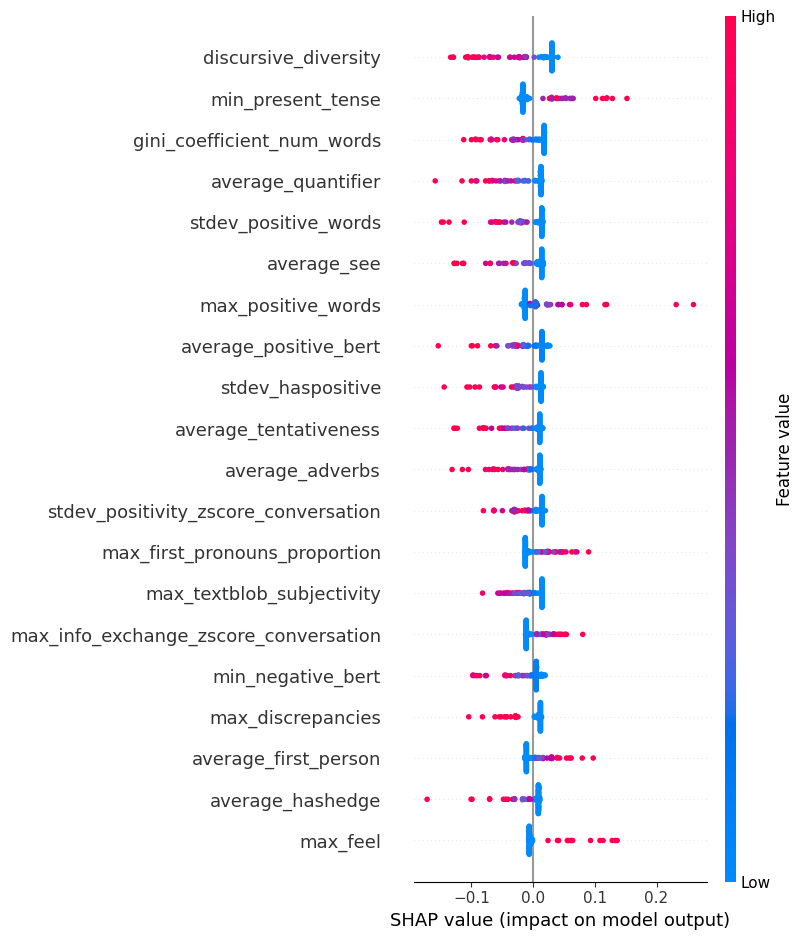

In [28]:
shap.summary_plot(shap_values, X_val, feature_names=X_train.columns)